In [3]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/AnatSearchlight')
sys.path.append('/Users/aghavamp/Desktop/Projects/SUITPy')
import getpass
import importlib
import tqdm

import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel
import glob
import matplotlib.patches as patches
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Users/aghavamp/Desktop/Projects/bimanual_wrist/data/fMRI/FS_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7



# avg activity in ROI

### the volume data is loaded and ROIs are extracted

In [ ]:
glm = 1
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']
sn_list = [101,104,106,107,108,109,110,111,112,113,114,115]
hem = ['L','R']
atlas,_ = am.get_atlas('fs32k')
conds = ['lhand', 'rhand', 'bi']

psc_volume = {'sn': [], 'region': [], 'hem': [], 'cond': [], 'psc': [], 'lateral': []}
for k, r in enumerate(region_labels):
    for j, h in enumerate(hem):
        for i, sn in enumerate(sn_list):
            # ==========================================
            # DATA EXTRACTION
            # ==========================================
            #  Define atlas map
            white = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.white.32k.surf.gii') # Individual white surface
            pial = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.pial.32k.surf.gii') # Invividual pial surface
            mask = os.path.join(baseDir, f'glm{glm}', f's{sn}', 'mask.nii') # Mask in functional space for that subject

            for cond in conds:
                # File names for data extraction
                nii_names = os.path.join(baseDir, f'glm{glm}', f's{sn}', f"PSC_{cond}.nii")                
                psc_tmp = []
                
                atlas_tmp = atlas.get_hemisphere(j)
                subatlas = atlas_tmp.get_subatlas_image(os.path.join(atlasDir,f'ROI.32k.{h}.label.gii'), value=r)
                amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
                # Compute the voxels in native space
                amap.build()
                
                # This extract all the relevant voxels in native space
                psc_tmp = amap.extract_data_native([nii_names])

                # ========================================== 
                # store the data
                # ==========================================
                psc_volume['sn'].append(sn)
                psc_volume['region'].append(region_names[k])
                psc_volume['hem'].append(h)
                psc_volume['cond'].append(cond)
                psc_volume['psc'].append(np.nanmean(psc_tmp))

                if cond=='lhand' and h=='L':
                    psc_volume['lateral'].append('ipsi')
                elif cond=='lhand' and h=='R':
                    psc_volume['lateral'].append('contra')
                elif cond=='rhand' and h=='L':
                    psc_volume['lateral'].append('contra')
                elif cond=='rhand' and h=='R':
                    psc_volume['lateral'].append('ipsi')  
                else:
                    psc_volume['lateral'].append('bi')

psc_volume = pd.DataFrame(psc_volume)
psc_volume.to_csv(os.path.join(analysisDir, 'psc_volume.csv'), index=False)



### avg within each ROI is calculated

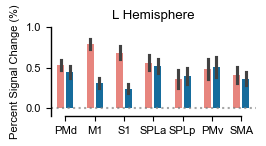

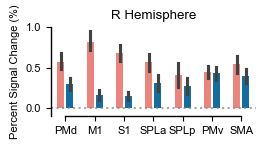

NameError: name 'df_uni' is not defined

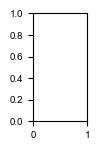

In [4]:
psc_volume = pd.read_csv(os.path.join(analysisDir, 'psc_volume.csv'))
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp']

# fig, ax = plt.subplots(figsize=(2.8,1.8))
# sns.boxplot(data=psc_volume, x='region', y='psc', hue='lateral', ax=ax, width=0.6, palette=['#0072B2','#F8766D','#808080'],  hue_order=['ipsi','contra','bi'], legend=False,
#             order=['M1','S1','PMd','PMv','SMA','SPLa','SPLp'], fliersize=0, linewidth=1, gap=0.4, fill=False)
# ax.axhline(0, color='grey', linestyle='--', linewidth=1.5, alpha=0.7)
# plt.ylim((-0.1,1.2))
# ax.set_yticks([0, 0.5, 1])
# # plt.title(f'Right Hemisphere')
# plt.ylabel('Mean PSC')
# plt.xlabel('')
# utils.please.make_it_pretty(ax=ax)
# plt.tight_layout()
# plt.savefig(f'../figures/PSC/average_PSC.pdf', bbox_inches="tight")
# plt.show()

plt.rcParams['font.size'] = 8
for h in ['L','R']:
    fig, ax = plt.subplots(figsize=(2.7,1.5))
    df_uni_h = psc_volume[(psc_volume.cond!='bi') & (psc_volume.hem==h)].copy()
    sns.barplot(data=df_uni_h, x='region', y='psc', hue='lateral', ax=ax, width=0.6, palette=['#F8766D','#0072B2'],  hue_order=['contra','ipsi'], legend=False,
                order=['PMd','M1','S1','SPLa','SPLp','PMv','SMA'], linewidth=1, gap=0.2, fill=True)
    ax.axhline(0, color='grey', linestyle=':', linewidth=1.5, alpha=0.7)
    plt.ylim((-0.1,1))
    ax.set_yticks([0, 0.5, 1])
    plt.title(f'{h} Hemisphere')
    plt.ylabel('Percent Signal Change (%)')
    plt.xlabel('')
    utils.please.make_it_pretty(ax=ax)
    plt.tight_layout()
    # plt.savefig(f'../figures/PSC/average_PSC_barplot.pdf', bbox_inches="tight")
    plt.show()

# make 1 small plot per region:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
for r in regions:
    for h in ['L','R']:
        fig, ax = plt.subplots(figsize=(0.7,1.4))
        df_r = df_uni[(df_uni.region==r) & (df_uni.hem==h)].copy()
        sns.barplot(data=df_r, x='lateral', y='psc', hue='lateral', ax=ax, width=1, gap=0, palette=['#F8766D','#0072B2'],  order=['contra','ipsi'], hue_order=['contra', 'ipsi'], linewidth=0.2, fill=True, legend=False)
        # ax.axhline(0, color='grey', linestyle=':', linewidth=1.5, alpha=0.7)
        plt.xlim((-1,2))
        plt.ylim((0,1.2))
        ax.set_yticks([0, 0.5, 1])
        plt.title(f'{h} {r}')
        plt.xlabel('')
        plt.xticks([])
        plt.ylabel('')
        # utils.please.make_it_pretty(ax=ax)
        plt.tight_layout()
        plt.savefig(f'../figures/PSC/average_bar_{h.lower()}{r}.pdf', bbox_inches="tight")
        plt.close()

# print t-test contra-vs-ipsi for df_uni:
from scipy.stats import ttest_rel
results = {'region':[], 't-stat':[], 'dof':[], 'p-val':[]}
print('\nContra vs Ipsi two-sided:')
for r in regions:
    for h in ['L','R']:
        df_tmp = df_uni[(df_uni.region==r) & (df_uni.hem==h)]
        data_contra = df_tmp[df_tmp.lateral=='contra']['psc']
        data_ipsi = df_tmp[df_tmp.lateral=='ipsi']['psc']
        tstat, pval = ttest_rel(data_contra, data_ipsi, alternative='two-sided')
        results['region'].append(f'{r}_{h}')
        results['dof'].append(len(data_contra)-1)
        results['t-stat'].append(tstat)
        results['p-val'].append(pval)
    # also do combined hem:
    # data_contra = df_uni[(df_uni.region==r) & (df_uni.lateral=='contra')]['psc']
    # data_ipsi = df_uni[(df_uni.region==r) & (df_uni.lateral=='ipsi')]['psc']
    # tstat, pval = ttest_rel(data_contra, data_ipsi)
    # results['region'].append(r)
    # results['dof'].append(len(data_contra)-1)
    # results['t-stat'].append(tstat)
    # results['p-val'].append(pval)
    results_df = pd.DataFrame(results)
print(results_df)




### STATs within ROI and HEM

In [ ]:
print("t-test {ROI} {hem} {lateral} != 0:")
from scipy.stats import ttest_1samp

df_uni = psc_volume[psc_volume.cond!='bi'].copy().reset_index(drop=True)
stats_df = {'region':[], 'hem':[], 'lateral':[], 't-stat':[], 'p-unc':[]}
for r in regions:
    for h in ['L','R']:
        for lateral in ['contra','ipsi']:
            df_tmp = df_uni[(df_uni.region==r) & (df_uni.hem==h) & (df_uni.lateral==lateral)]
            data_all = df_tmp['psc']
            tstat, pval = ttest_1samp(data_all, 0, alternative='two-sided')
            stats_df['region'].append(r)
            stats_df['hem'].append(h)
            stats_df['lateral'].append(lateral)
            stats_df['t-stat'].append(tstat)
            stats_df['p-unc'].append(pval)

df_uni = pd.DataFrame(stats_df)
# multiple comparisons correction across ROIs for each hemisphere:
from statsmodels.stats.multitest import multipletests
for h in ['L','R']:
    for lateral in ['contra','ipsi']:
        df_sub = df_uni[(df_uni.hem==h) & (df_uni.lateral==lateral)]
        reject, p_corr, _, _ = multipletests(df_sub['p-unc'], alpha=0.05, method='fdr_bh')
        df_uni.loc[df_sub.index, 'p-corr'] = p_corr
        df_uni.loc[df_sub.index, 'reject_H0'] = reject

print(df_uni)



t-test {ROI} {hem} {lateral} != 0:
   region hem lateral     t-stat         p-unc        p-corr reject_H0
0      M1   L  contra  24.537597  5.901628e-11  4.131140e-10      True
1      M1   L    ipsi   9.596371  1.114125e-06  2.599626e-06      True
2      M1   R  contra  12.770677  6.119729e-08  2.141905e-07      True
3      M1   R    ipsi   4.985893  4.115909e-04  4.801894e-04      True
4      S1   L  contra  16.050389  5.578187e-09  1.301577e-08      True
5      S1   L    ipsi   7.628408  1.023723e-05  1.194343e-05      True
6      S1   R  contra  13.090421  4.735141e-08  2.141905e-07      True
7      S1   R    ipsi   5.486366  1.901026e-04  2.661436e-04      True
8     PMd   L  contra  16.467370  4.250978e-09  1.301577e-08      True
9     PMd   L    ipsi  12.106397  1.062325e-07  7.436277e-07      True
10    PMd   R  contra  11.114579  2.547196e-07  4.457593e-07      True
11    PMd   R    ipsi   8.125453  5.632154e-06  1.314169e-05      True
12    PMv   L  contra   7.593187  1.069122

### STATs within ROI hem averaged

In [ ]:
print("t-test ROI != 0:")
from scipy.stats import ttest_1samp

df_uni = psc_volume[psc_volume.cond!='bi'].copy().reset_index(drop=True)
df_avg = df_uni.groupby(['sn','region','lateral'], as_index=False).agg({
    'psc':'mean'
})
for r in regions:
    for lateral in ['contra','ipsi']:
        df_tmp = df_avg[(df_avg.region==r) & (df_avg.lateral==lateral)]
        data_all = df_tmp['psc']
        tstat, pval = ttest_1samp(data_all, 0)
        print(f'    {r} {lateral}: t({len(data_all)-1})={tstat:.2f}, p={pval:.2e}')


t-test ROI != 0:
    M1 contra: t(11)=18.18, p=1.48e-09
    M1 ipsi: t(11)=7.76, p=8.70e-06
    S1 contra: t(11)=15.62, p=7.43e-09
    S1 ipsi: t(11)=7.16, p=1.84e-05
    PMd contra: t(11)=15.16, p=1.02e-08
    PMd ipsi: t(11)=10.73, p=3.64e-07
    PMv contra: t(11)=9.40, p=1.36e-06
    PMv ipsi: t(11)=9.11, p=1.87e-06
    SMA contra: t(11)=9.45, p=1.30e-06
    SMA ipsi: t(11)=8.67, p=3.03e-06
    SPLa contra: t(11)=10.46, p=4.69e-07
    SPLa ipsi: t(11)=9.14, p=1.81e-06
    SPLp contra: t(11)=5.91, p=1.02e-04
    SPLp ipsi: t(11)=6.29, p=5.95e-05


### ANOVA HEM & Laterality

Doing anova with two factors of hem and laterality. If there is an interaction between the two, contra and ipsilateral behave differently in left and right cortex

In [ ]:
from statsmodels.stats.anova import AnovaRM
print("ANOVA within region:")

df_uni = psc_volume[psc_volume.cond!='bi'].copy().reset_index(drop=True)
for r in regions:
    df_tmp = df_uni[df_uni.region==r]
    anova = AnovaRM(df_tmp, 'psc', subject='sn', within=['lateral','hem']).fit()
    print(f'\n*********** {r} *********************')
    print(anova)



ANOVA within region:

*********** M1 *********************
                  Anova
            F Value  Num DF  Den DF Pr > F
------------------------------------------
lateral     384.5207 1.0000 11.0000 0.0000
hem           4.7568 1.0000 11.0000 0.0518
lateral:hem  11.4217 1.0000 11.0000 0.0061


*********** S1 *********************
                  Anova
            F Value  Num DF  Den DF Pr > F
------------------------------------------
lateral     237.5200 1.0000 11.0000 0.0000
hem           4.6364 1.0000 11.0000 0.0543
lateral:hem   4.0850 1.0000 11.0000 0.0683


*********** PMd *********************
                  Anova
            F Value  Num DF  Den DF Pr > F
------------------------------------------
lateral     172.7322 1.0000 11.0000 0.0000
hem           3.2562 1.0000 11.0000 0.0986
lateral:hem  25.4511 1.0000 11.0000 0.0004


*********** PMv *********************
                  Anova
            F Value Num DF  Den DF Pr > F
---------------------------------------

### 3-way rm ANOVA

In [51]:
from statsmodels.stats.anova import AnovaRM
print("ANOVA within region:")

df_uni = psc_volume[psc_volume.cond!='bi'].copy().reset_index(drop=True)
anova = AnovaRM(df_uni, 'psc', subject='sn', within=['lateral','hem','region']).fit()
print(anova)

# Extract p-values with scientific notation
print("\nP-values in scientific notation:")
for index, row in anova.anova_table.iterrows():
    print(f"{index}: F = {row['F Value']:.4f}, p = {row['Pr > F']:.3e}")



ANOVA within region:
                      Anova
                   F Value  Num DF  Den DF Pr > F
-------------------------------------------------
lateral            226.2277 1.0000 11.0000 0.0000
hem                  7.9072 1.0000 11.0000 0.0169
region               6.6917 7.0000 77.0000 0.0000
lateral:hem         12.8863 1.0000 11.0000 0.0042
lateral:region     158.6929 7.0000 77.0000 0.0000
hem:region           4.3337 7.0000 77.0000 0.0004
lateral:hem:region   7.4211 7.0000 77.0000 0.0000


P-values in scientific notation:
lateral: F = 226.2277, p = 1.107e-08
hem: F = 7.9072, p = 1.691e-02
region: F = 6.6917, p = 3.425e-06
lateral:hem: F = 12.8863, p = 4.245e-03
lateral:region: F = 158.6929, p = 4.687e-43
hem:region: F = 4.3337, p = 4.314e-04
lateral:hem:region: F = 7.4211, p = 8.377e-07


### post-hoc ttest, contra_vs_ipsi

In [57]:
import pandas as pd
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# 1. Prepare storage for results
results = []
df_uni = psc_volume[psc_volume.cond!='bi'].copy().reset_index(drop=True)
regions = df_uni['region'].unique()
hemispheres = ['L', 'R']

print(f"Contra vs Ipsi:")

# 2. Loop through every combination of Region and Hemisphere
for roi in regions:
    for hem in hemispheres:
        # Subset data for this specific ROI and Hemisphere
        subset = df_uni[(df_uni['region'] == roi) & (df_uni['hem'] == hem)]
        
        # Pivot to get contra/ipsi side-by-side for each subject
        subset_wide = subset.pivot(index='sn', columns='lateral', values='psc')
        
        # Perform paired t-test
        t_stat, p_val = ttest_rel(subset_wide['contra'], subset_wide['ipsi'])
        
        # Calculate mean difference
        mean_diff = subset_wide['contra'].mean() - subset_wide['ipsi'].mean()
        
        results.append({
            'region': roi,
            'hemisphere': hem,
            'mean_diff (C-I)': mean_diff,
            't_stat': t_stat,
            'p_unc': p_val
        })

# 3. Create DataFrame
df_res = pd.DataFrame(results)

# 4. Apply FDR Correction across ALL tests (e.g., 16 tests)
reject, p_corr, _, _ = multipletests(df_res['p_unc'], method='fdr_bh')

df_res['p_corr'] = p_corr
df_res['significant'] = reject

# 5. Display results sorted by significance
print(df_res)



Contra vs Ipsi:
   region hemisphere  mean_diff (C-I)     t_stat         p_unc        p_corr  \
0      S1          L         0.446500  15.962884  5.910394e-09  4.728315e-08   
1      S1          R         0.529576  11.645540  1.582219e-07  6.328875e-07   
2      M1          L         0.489677  24.678889  5.546185e-11  8.873896e-10   
3      M1          R         0.663646  12.865573  5.667800e-08  3.022827e-07   
4     PMd          L         0.086116   7.040606  2.152689e-05  4.305377e-05   
5     PMd          R         0.277624   8.988970  2.121457e-06  4.849045e-06   
6     PMv          L        -0.020219  -1.047906  3.171614e-01  3.383055e-01   
7     PMv          R         0.009929   0.785859  4.485475e-01  4.485475e-01   
8     SMA          L         0.044506   2.786075  1.771044e-02  2.833671e-02   
9     SMA          R         0.149173   9.039090  2.009089e-06  4.849045e-06   
10     V1          L        -0.058146  -1.559985  1.470531e-01  1.809884e-01   
11     V1          R    

### post-hoc ttest, L vs R hem

In [63]:
results = []
df_uni = psc_volume[psc_volume.cond!='bi'].copy().reset_index(drop=True)
regions = df_uni['region'].unique()

for roi_name in regions:
    df_roi = df_uni[df_uni['region'] == roi_name].copy()
    
    df_wide = df_roi.pivot_table(
        index=['sn', 'hem'], 
        columns='lateral', 
        values='psc'
    ).reset_index()
    
    df_wide['laterality_index'] = df_wide['contra'] - df_wide['ipsi']
    
    df_compare = df_wide.pivot_table(
        index='sn', 
        columns='hem', 
        values='laterality_index'
    ).reset_index()
    
    t_stat, p_val = ttest_rel(df_compare['L'], df_compare['R'])
    mean_diff = df_compare['L'].mean() - df_compare['R'].mean()
    
    results.append({
        'region': roi_name,
        'mean_LI_diff': mean_diff,
        't_stat': t_stat,
        'p_unc': p_val
    })

results_df = pd.DataFrame(results)

# Apply FDR correction
reject, p_corr, _, _ = multipletests(results_df['p_unc'], method='fdr_bh')
results_df['p_corr'] = p_corr
results_df['significant'] = reject

print(results_df)



  region  mean_LI_diff    t_stat     p_unc    p_corr  significant
0     S1     -0.083076 -2.021139  0.068283  0.091043        False
1     M1     -0.173968 -3.379602  0.006147  0.012294         True
2    PMd     -0.191508 -5.044904  0.000375  0.001500         True
3    PMv     -0.030149 -1.039363  0.320943  0.366792        False
4    SMA     -0.104667 -3.776567  0.003065  0.008174         True
5     V1      0.003067  0.051867  0.959565  0.959565        False
6   SPLa     -0.220723 -6.393862  0.000051  0.000410         True
7   SPLp     -0.169252 -3.005529  0.011961  0.019138         True


### post-hoc M1-S1 laterality vs others

In [66]:
import pandas as pd
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# 1. Aggregate hemispheres first to get one value per Subject/Region/Condition
df_uni = psc_volume[psc_volume.cond!='bi'].copy().reset_index(drop=True)
df_avg_hem = df_uni.groupby(['sn', 'region', 'lateral'])['psc'].mean().reset_index()

# 2. Pivot to get Contra and Ipsi columns
df_wide = df_avg_hem.pivot_table(
    index=['sn', 'region'], 
    columns='lateral', 
    values='psc'
).reset_index()

# 3. Calculate Laterality Index (LI)
df_wide['LI'] = df_wide['contra'] - df_wide['ipsi']

# 1. Create the Reference Score (Average of M1 and S1 for each subject)
target_rois = ['M1', 'S1']
df_ref = df_wide[df_wide['region'].isin(target_rois)].groupby('sn')['LI'].mean().reset_index()
df_ref = df_ref.rename(columns={'LI': 'LI_M1_S1'})

# 2. Identify "Other" ROIs
all_rois = df_wide['region'].unique()
other_rois = [r for r in all_rois if r not in target_rois]

results = []

print(f"Comparing (M1+S1) Laterality against ROIs...")

# 3. Loop through other ROIs and perform paired t-tests
for roi in other_rois:
    # Get LI for this specific ROI
    df_other = df_wide[df_wide['region'] == roi][['sn', 'LI']].rename(columns={'LI': 'LI_other'})
    
    # Merge with Reference data by Subject to ensure pairing
    # (Inner join ensures we only test subjects present in both)
    df_test = pd.merge(df_ref, df_other, on='sn')
    
    # Paired T-test
    t_stat, p_val = ttest_rel(df_test['LI_M1_S1'], df_test['LI_other'])
    
    # Mean difference (Reference - Other)
    # Positive diff means M1+S1 is MORE lateralized than the other ROI
    mean_diff = df_test['LI_M1_S1'].mean() - df_test['LI_other'].mean()
    
    results.append({
        'comparison': f'(M1+S1) vs {roi}',
        'diff_mean': mean_diff,
        't_stat': t_stat,
        'p_unc': p_val
    })

# 4. Create DataFrame
res_df = pd.DataFrame(results)

# 5. Apply FDR Correction (Benjamini-Hochberg)
reject, p_corr, _, _ = multipletests(res_df['p_unc'], method='fdr_bh')
res_df['p_corr'] = p_corr
res_df['significant'] = reject

# Display results
print(res_df)




Comparing (M1+S1) Laterality against ROIs...
        comparison  diff_mean     t_stat         p_unc        p_corr  \
0   (M1+S1) vs PMd   0.350479  15.686675  7.108222e-09  1.269834e-08   
1   (M1+S1) vs PMv   0.537495  16.343582  4.604992e-09  1.269834e-08   
2   (M1+S1) vs SMA   0.435510  15.429179  8.465557e-09  1.269834e-08   
3  (M1+S1) vs SPLa   0.383727  13.620319  3.132850e-08  3.132850e-08   
4  (M1+S1) vs SPLp   0.480189  14.541971  1.578895e-08  1.894675e-08   
5    (M1+S1) vs V1   0.592030  17.124613  2.805501e-09  1.269834e-08   

   significant  
0         True  
1         True  
2         True  
3         True  
4         True  
5         True  


## stats ANOVA

In [3]:
from statsmodels.stats.anova import AnovaRM
# Multiple-comparisons corrections
from statsmodels.stats.multitest import multipletests
# Post-hoc paired t-tests for all condition pairs
from itertools import combinations
from scipy import stats

regions = ['SMA','PMv','PMd','M1','S1','SPLa','SPLp']
lateral = ['ipsi','contra','bi']

for hem in ['L','R']:
    for region in regions:
        df_tmp = df[(df.region==region) & (df.hem==hem)]
        # Repeated-measures ANOVA
        anova = AnovaRM(df_tmp, depvar='psc', subject='sn', within=['lateral']).fit()
        print(f'\n\n==================== {region}_{hem} ====================')
        print(anova)

        pairs = list(combinations(lateral, 2))
        wide = df_tmp.pivot(index='sn', columns='lateral', values='psc')  # subject x condition
        results = []
        for a,b in pairs:
            t, p = stats.ttest_rel(wide[a], wide[b])  # paired t-test
            results.append({'A': a, 'B': b, 't': t, 'p_unc': p})

        res_df = pd.DataFrame(results)

        # Holm-Bonferroni (FWER control)
        rejected_holm, p_holm, _, _ = multipletests(res_df['p_unc'].values, alpha=0.05, method='holm')
        res_df['p_holm'] = p_holm
        res_df['sig_holm'] = rejected_holm

        # Benjamini–Hochberg FDR (q=0.05)
        rejected_fdr, p_fdr, _, _ = multipletests(res_df['p_unc'].values, alpha=0.05, method='fdr_bh')
        res_df['p_fdr'] = p_fdr
        res_df['sig_fdr'] = rejected_fdr

        print("Post-hoc paired t-tests with Holm and FDR:")
        print(res_df)





==================== SMA_L ====================
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
lateral 40.5280 2.0000 22.0000 0.0000

Post-hoc paired t-tests with Holm and FDR:
        A       B         t     p_unc    p_holm  sig_holm     p_fdr  sig_fdr
0    ipsi  contra -2.754852  0.018727  0.018727      True  0.018727     True
1    ipsi      bi -8.513270  0.000004  0.000011      True  0.000011     True
2  contra      bi -7.658129  0.000010  0.000020      True  0.000015     True


==================== PMv_L ====================
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
lateral  9.3537 2.0000 22.0000 0.0011

Post-hoc paired t-tests with Holm and FDR:
        A       B         t     p_unc    p_holm  sig_holm     p_fdr  sig_fdr
0    ipsi  contra -0.039782  0.968980  0.968980     False  0.968980    False
1    ipsi      bi -3.437777  0.005546  0.011093      True  0.008320     True
2

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x104188cd0>>
Traceback (most recent call last):
  File "/Users/aghavamp/Desktop/Projects/bimanual_wrist/.conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Post-hoc paired t-tests with Holm and FDR:
        A       B          t         p_unc        p_holm  sig_holm  \
0    ipsi  contra -14.124096  2.143393e-08  6.430179e-08      True   
1    ipsi      bi -12.661082  6.690885e-08  1.338177e-07      True   
2  contra      bi  -0.348193  7.342671e-01  7.342671e-01     False   

          p_fdr  sig_fdr  
0  6.430179e-08     True  
1  1.003633e-07     True  
2  7.342671e-01    False  


==================== SPLa_L ====================
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
lateral 13.0688 2.0000 22.0000 0.0002

Post-hoc paired t-tests with Holm and FDR:
        A       B         t     p_unc    p_holm  sig_holm     p_fdr  sig_fdr
0    ipsi  contra -0.869801  0.402991  0.402991     False  0.402991    False
1    ipsi      bi -4.982320  0.000414  0.001242      True  0.001242     True
2  contra      bi -3.802829  0.002929  0.005858      True  0.004393     True


==================== SPLp_L